In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
rng_seed = 1
np.random.seed(rng_seed)

In [3]:
data_dir = '../data'
fn = f'{data_dir}/MWDD-export-preprocessed.csv'
df = pd.read_csv(fn)

df.dtypes

wdid                object
icrsra              object
icrsdec             object
spectype            object
teff               float64
logg               float64
mass               float64
logL               float64
age                float64
Dpc                float64
ismag                 bool
su                 float64
Dsu                float64
sg                 float64
Dsg                float64
sr                 float64
Dsr                float64
si                 float64
Dsi                float64
sz                 float64
Dsz                float64
EBmV               float64
su-sg              float64
sg-sr              float64
sr-si              float64
si-sz              float64
spectype_simple     object
dtype: object

In [4]:
physicals = ['teff', 'logg', 'mass']

filters = ['su', 'sg', 'sr', 'si', 'sz']
err_filters = [f'D{f}' for f in filters]

colors = ['su-sg', 'sg-sr', 'sr-si', 'si-sz']

binaries = ['ismag']

col_input = [*physicals, *filters, *colors, *binaries]

In [5]:
df.value_counts('spectype_simple') / len(df)

spectype_simple
DA    0.843261
DB    0.066736
DC    0.052952
DZ    0.021963
DQ    0.011601
DO    0.003487
Name: count, dtype: float64

80% of the data is classified as a DA WD. To not overwhelm our model with DA objects, we'll reduce the number of DAs in our training set and split the data into DA vs. non-DA. It turns out that this drastically improves the performance of the model for each model.

In [6]:
df['DA'] = df['spectype_simple'] == 'DA'

In [7]:
factor = 2.
n_desired = int((~df['DA']).sum() * factor)
n_DA = df['DA'].sum()
n_remove = df['DA'].sum() - n_desired
drop_ind = np.random.choice(df[df['DA']].index, n_remove, replace=False)
df.drop(drop_ind, inplace=True)
print(f'DA samples dropped: {n_remove} / {n_DA} ({n_desired} remaining)')

DA samples dropped: 16258 / 25878 (9620 remaining)


First we need to transform and scale our input, and setup the model. We'll do a grid search (with cross-validation) to find some reasonable model parameters.

In [8]:
transform_physicals = MinMaxScaler()
transform_filters = MinMaxScaler()
transform_colors = MinMaxScaler()
transform_binaries = Binarizer()

transformer = ColumnTransformer([
    ('physicals', transform_physicals, physicals),
    ('filters', transform_filters, filters),
    ('colors', transform_colors, colors),
    ('binaries', transform_binaries, binaries),
], remainder='passthrough')

# Setup models
models = {
    'RF': {
        'model': RandomForestClassifier,
        'set_params': {
            'random_state': rng_seed,
        },
        'param_grid': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 10, 20],
        },
    },
    'GB': {
        'model': HistGradientBoostingClassifier,
        'set_params': {
            'random_state': rng_seed,
        },
        'param_grid': {
            'learning_rate': [0.1, 0.3, 0.05],
            'max_depth': [None, 50, 75],
        },
    },
    'KNN': {
        'model': KNeighborsClassifier,
        'set_params': {
        },
        'param_grid': {
            'n_neighbors': [5, 10, 15, 20],
        },
    },
}

# Choose model
model_key = 'RF'

model = models[model_key]
pipeline = Pipeline([
    ('transformer', transformer),
    ('model',
         GridSearchCV(
             model['model'](**model['set_params']),
             param_grid=model['param_grid'],
             cv=2,
             refit=True,
        )
    )
])

First do DA vs. non-DA:

In [9]:
X = df[col_input]
y = df['DA']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.175, random_state=rng_seed)

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

We can make a confusion matrix and get some statistics such as precision and recall:

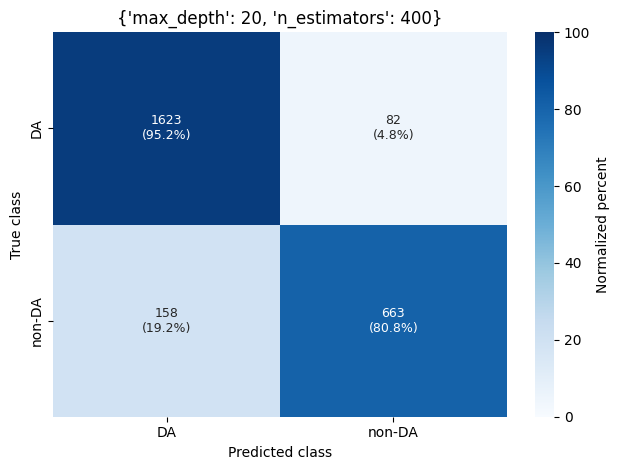

In [10]:
fig, ax = plt.subplots()

classes = ['DA', 'non-DA']

cm_counts = confusion_matrix(y_test, y_predict, labels=[1, 0])
cm_norm = confusion_matrix(y_test, y_predict, labels=[1, 0], normalize='true') * 100.

counts = pd.DataFrame(cm_counts)
perc = pd.DataFrame(cm_norm)
annot_count = counts.astype(str)
annot_pct = perc.round(1).astype(str)
annot = annot_count + '\n(' + annot_pct + '%)'

sns.heatmap(cm_norm, ax=ax, annot=annot, fmt='', vmin=0., vmax=100.,
            annot_kws={'fontsize': 9}, cmap='Blues', cbar_kws={'label': 'Normalized percent'})

ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_title(f'{model_key} : {pipeline["model"].best_params_}')

plt.tight_layout()
plt.show()

In [11]:
stats = precision_recall_fscore_support(y_test, y_predict)
df_stats = pd.DataFrame(stats, index=['precision', 'recall', 'fscore', 'support'], columns=['DA', 'non-DA'])
df_stats

,DA,non-DA
precision,0.889933,0.911286
recall,0.807552,0.951906
fscore,0.846743,0.931153
support,821.000000,1705.000000


For random forest models, we can also show the impurity-based feature importance of each feature in distinguishing different classes.

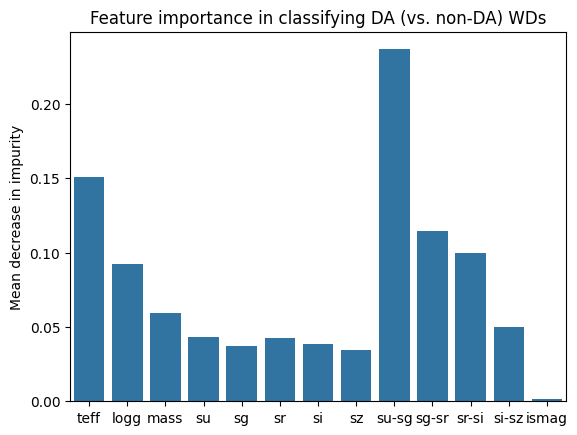

In [12]:
if model_key == 'RF':
    fig, ax = plt.subplots()
    
    importances = pd.Series(pipeline['model'].best_estimator_.feature_importances_, index=col_input)
    sns.barplot(importances, ax=ax)
    
    ax.set_ylabel('Mean decrease in impurity')
    ax.set_title('Feature importance in classifying DA (vs. non-DA) WDs')
    
    plt.show()

Now classify non-DAs separately:

In [13]:
df_nonDA = df[~df['DA']]
X = df_nonDA[col_input]
y = df_nonDA['spectype_simple']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=rng_seed)

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

We can do the same evaluation as above:

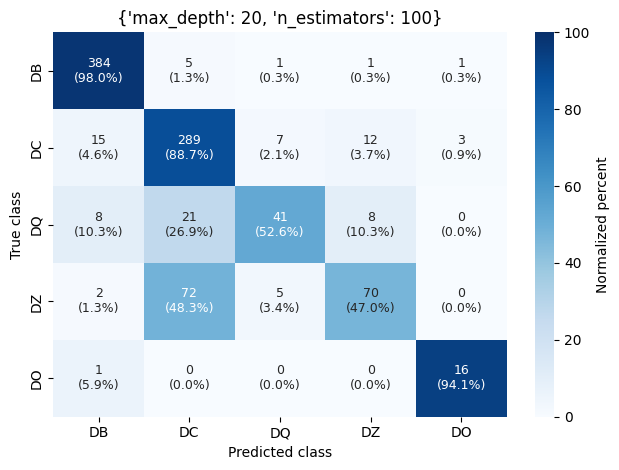

In [14]:
fig, ax = plt.subplots()

classes = ['DB', 'DC', 'DQ', 'DZ', 'DO']

cm_counts = confusion_matrix(y_test, y_predict, labels=classes)
cm_norm = confusion_matrix(y_test, y_predict, labels=classes, normalize='true') * 100.

counts = pd.DataFrame(cm_counts)
perc = pd.DataFrame(cm_norm)
annot_count = counts.astype(str)
annot_pct = perc.round(1).astype(str)
annot = annot_count + '\n(' + annot_pct + '%)'

sns.heatmap(cm_norm, ax=ax, annot=annot, fmt='', vmin=0., vmax=100.,
            annot_kws={'fontsize': 9}, cmap='Blues', cbar_kws={'label': 'Normalized percent'})

ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_title(f'{model_key} : {pipeline["model"].best_params_}')

plt.tight_layout()
plt.show()

In [15]:
stats = precision_recall_fscore_support(y_test, y_predict)
df_stats = pd.DataFrame(stats, index=['precision', 'recall', 'fscore', 'support'], columns=classes)
df_stats

,DB,DC,DQ,DZ,DO
precision,0.936585,0.746770,0.800000,0.759259,0.769231
recall,0.979592,0.886503,0.941176,0.525641,0.469799
fscore,0.957606,0.810659,0.864865,0.621212,0.583333
support,392.000000,326.000000,17.000000,78.000000,149.000000


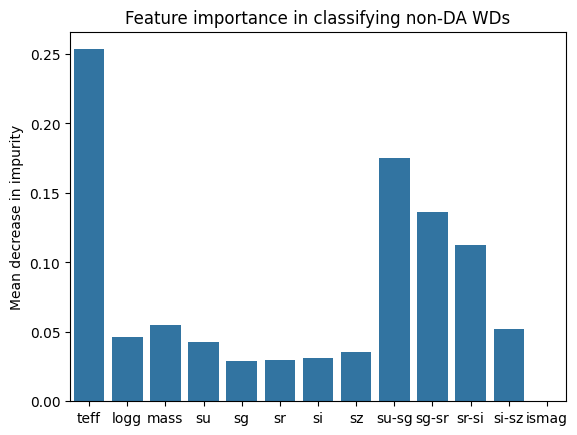

In [16]:
if model_key == 'RF':
    fig, ax = plt.subplots()
    
    importances = pd.Series(pipeline['model'].best_estimator_.feature_importances_, index=col_input)
    sns.barplot(importances, ax=ax)
    
    ax.set_ylabel('Mean decrease in impurity')
    ax.set_title('Feature importance in classifying non-DA WDs')
    
    plt.show()